<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

## A Safari of Deep Learning Procedures
Tailored for a Diverse Array of Intelligences Keen To Learn. Resource provided by Colin Conwell, Neuro 140 at Harvard.
<br>To navigate, simply click on a cell and hit **Shift + Enter**.


##Working With Colaboratory

###Why Colaboratory? What's it good for?

Colaboratory is effectively a 'virtual machine' powered by Google's cloud computing resources that requires no installation and no money. And sometimes (when Google's feeling benevolent) it even allows you to use a fancy graphics processing unit (or even fancier tensor processing unit) to power some basic deep learning.


### Interacting with Colaboratory

**By Code or By Interface**: A sweet feature of Colaboratory is its neat take on interactivity -- called 'forms' -- which allows you to create graphical interfaces on the fly. You'll increasingly see this in various online tutorials, and we'll even use a few of them today. If, at any time, you want to see the code behind the interface, simply click **Edit → Show/Hide Code** on the relevant cell.

When first you access this notebook, it's likely you'll be able only to view it. 

To edit and more freely interact with the notebook, navigate to **File > Save a Copy in Drive**

The following cell creates a graph with some variables you can change.


*   **NumberOfPoints**: The number of data points to be plotted.
*   **Polynomial:** How much you allow your fitted line to 'bend' to fit the data. Input a value of 1 and the line will be perfectly straight.
*  **Variance**: How 'spread out' the data points will be. Higher values mean greater spread.
* **Colors**: Choose some colors for your data points and fitted line. [Here](https://matplotlib.org/mpl_examples/color/named_colors.png) are your options.

Once you've set the parameters to your desired values, simply click **Shift + Enter** to generate the graph.

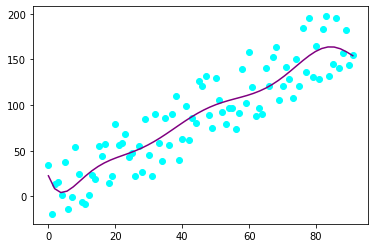

In [0]:
#@title Graphical Parameters

NumberOfPoints = 92 #@param {type:"slider", min:0, max:100, step:1}
Polynomial = 8 #@param {type:"slider", min:1, max:10, step:1}
Variance = 40 #@param {type:"slider", min:0, max:100, step:1}
DotColor = 'Cyan' #@param {type:"string"}
LineColor = 'Purple' #@param {type:"string"}

#import the prerequisite libraries
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import random

#define the x and y vectors
x = np.arange(NumberOfPoints)
y = [x_i + random.uniform(x_i-Variance, x_i+Variance) for x_i in x]

# calculate polynomial
z = np.polyfit(x, y, Polynomial)
f = np.poly1d(z)

# calculate the points through which the line will cross
x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)


plt.plot(x,y,'o', color = DotColor)
plt.plot(x_new, y_new, color = LineColor)
ax = plt.gca()
fig = plt.gcf()

In [0]:
#@title Random Sequence Generator (the Fisher-Yates Shuffle)

NumberOfElements = 12 #@param {type:"slider", min:0, max:25, step:1}

from random import shuffle
x = [[i] for i in range(1,NumberOfElements+1)]
shuffle(x)
print(x)

[[11], [3], [7], [12], [8], [6], [10], [5], [2], [1], [4], [9]]


###Release the Power of the GPU!

Before running the cells below, be sure to adjust the notebook settings such that you're taking advantage of Colab's hardware acceleration (which we'll need for the deep learning component of this tutorial). To do so, navigate to **Runtime > Change Runtime Type** and under **Hardware accelerator** change the dropdown such that it says **GPU** or **TPU**. Once you've changed the runtime type, your notebook settings should appear as follows.

<img height="300px" src="https://www.kdnuggets.com/wp-content/uploads/colab-settings-1.png" vspace='10px' hspace='10px'>


##Deep Learning on Tabular Data

This is a type of data the vast majority of you will have encountered at some point. It's the data you get in experiments, the data you scrape from the web, any data before you've made that data into something else. And yes! You can do deep learning on it.

The following is a mock dataset that is pretty much entirely fake. It's originally a fake salary dataset that I've now converted into a fake psychiatric dataset, with the variable of interest being 'suicide.risk'. (Full Disclosure: I adapted this from a machine learning tutorial for a group of clinical psychologists)

Without further ado, then, let's get started!

### Data Preparation: Getting Your Data in Ship Machine-Learning Shape

The first (and usually most time-consuming) step of all machine learning is data wrangling. Machines are very particular about how you feed them data and will refuse to work until you have something resembling what they like.

The first thing we'll do then is to import some python libraries and download our data into the Colab interface.

In [0]:
import warnings
warnings.filterwarnings("ignore")

from fastai.tabular import *

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

The sample data we have today is a has a combination of categorical and continuous predictors, and a final predicted target: 'salary', which for the sake of exposition we've binarized into above and below $50K.

In [0]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


One of the first things we need to do is to tell the machine learning algorithm which of our variables is categorical and which is continuous. We'll then define a set of procedures to preprocess these variables: these procedures including normalization for the continuous variables and the statistical imputation of missing values. 

We put our preprocessed data into something called a 'DataLoader', which will feed our data in chunks (as opposed to all at once) to the rather computationally expensive learning algorithms we'll be using today.

In [0]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

Importantly, we reserve a portion of the dataset as 'test' data -- data on which the algorithm will not be trained and which will serve as a benchmark's of the model's generalizability.

In [0]:
test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
data.show_batch(rows=10)

workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,target
Private,Assoc-voc,Married-civ-spouse,Sales,Husband,White,False,-0.1896,0.2728,0.3599,<50k
Self-emp-not-inc,Some-college,Married-civ-spouse,Exec-managerial,Husband,White,False,0.7632,-1.0438,-0.0312,<50k
Local-gov,Some-college,Divorced,Other-service,Unmarried,White,False,0.3968,0.0777,-0.0312,<50k
Local-gov,Masters,Married-civ-spouse,Prof-specialty,Wife,White,False,-0.7760,0.5728,1.5334,<50k
Private,Bachelors,Never-married,Tech-support,Own-child,Black,False,-1.1425,1.9426,1.1422,<50k
Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,0.2502,-0.6864,-0.4224,<50k
Private,Some-college,Never-married,Prof-specialty,Not-in-family,White,False,-1.2891,1.4849,-0.0312,<50k
State-gov,Some-college,Never-married,Tech-support,Not-in-family,White,False,-0.5561,-0.6322,-0.0312,<50k
Private,Bachelors,Married-civ-spouse,Craft-repair,Husband,White,False,0.3235,-0.1486,1.1422,<50k
Private,9th,Never-married,Machine-op-inspct,Not-in-family,White,False,0.3968,-0.2266,-1.9869,<50k


###Defining our Algorithm: A Deep Neural Network

Using Fastai's impressively packaged programming language, we'll instantiate a deep neural network in one line of code. The architecture of this network consists of an input layer, two hidden layers (with 200 and 100 nodes, respectively) and a final output (or) classification layer.

To optimize this network we'll use a learning rate finder to determine an ideal learning rate, and then, without further ado, set it loose!

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=42, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

Here we'll use a technique to find an optimal learning rate with which to train the model.

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


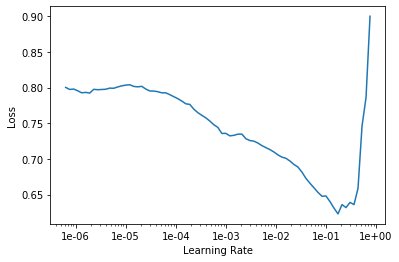

In [0]:
learn.recorder.plot()

(Based on the lowest point of the plot we'll choose a learning rate of *1e-1*; this may vary from run to run.)

In [0]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.377999,0.384455,0.830000,00:07
1,0.386142,0.399357,0.820000,00:07
2,0.385073,0.440838,0.755000,00:07
3,0.353136,0.369911,0.860000,00:07
4,0.352010,0.366767,0.855000,00:07


And voila! You've now fit and trained a neural network to predict suicide risk.

###Inference with Our Algorithm

We can now use our trained model to predict data it has not seen before. For example, what is the salary of the following profile?

In [0]:
row = df.iloc[0]
row

age                                49
workclass                     Private
fnlwgt                         101320
education                  Assoc-acdm
education-num                      12
marital-status     Married-civ-spouse
occupation                        NaN
relationship                     Wife
race                            White
sex                            Female
capital-gain                        0
capital-loss                     1902
hours-per-week                     40
native-country          United-States
salary                          >=50k
Name: 0, dtype: object

In [0]:
learn.predict(row)

(Category >=50k, tensor(1), tensor([0.4318, 0.5682]))

The model classifies this profile as making more than 50K.

To get a sense of how difficult this task, have a look at the following plots. These show the overlap of our target categories along the various variables we're using as predictors. As you can see, in many of these cases, there's a significant (if not almost total) overlap across the predictors, making any given point somewhat uninformative in the absence of the aggregate trends in other predictors.

This is the forté of deep neural networks: small, subtle patterns that are otherwise difficult to discern with the human eye.

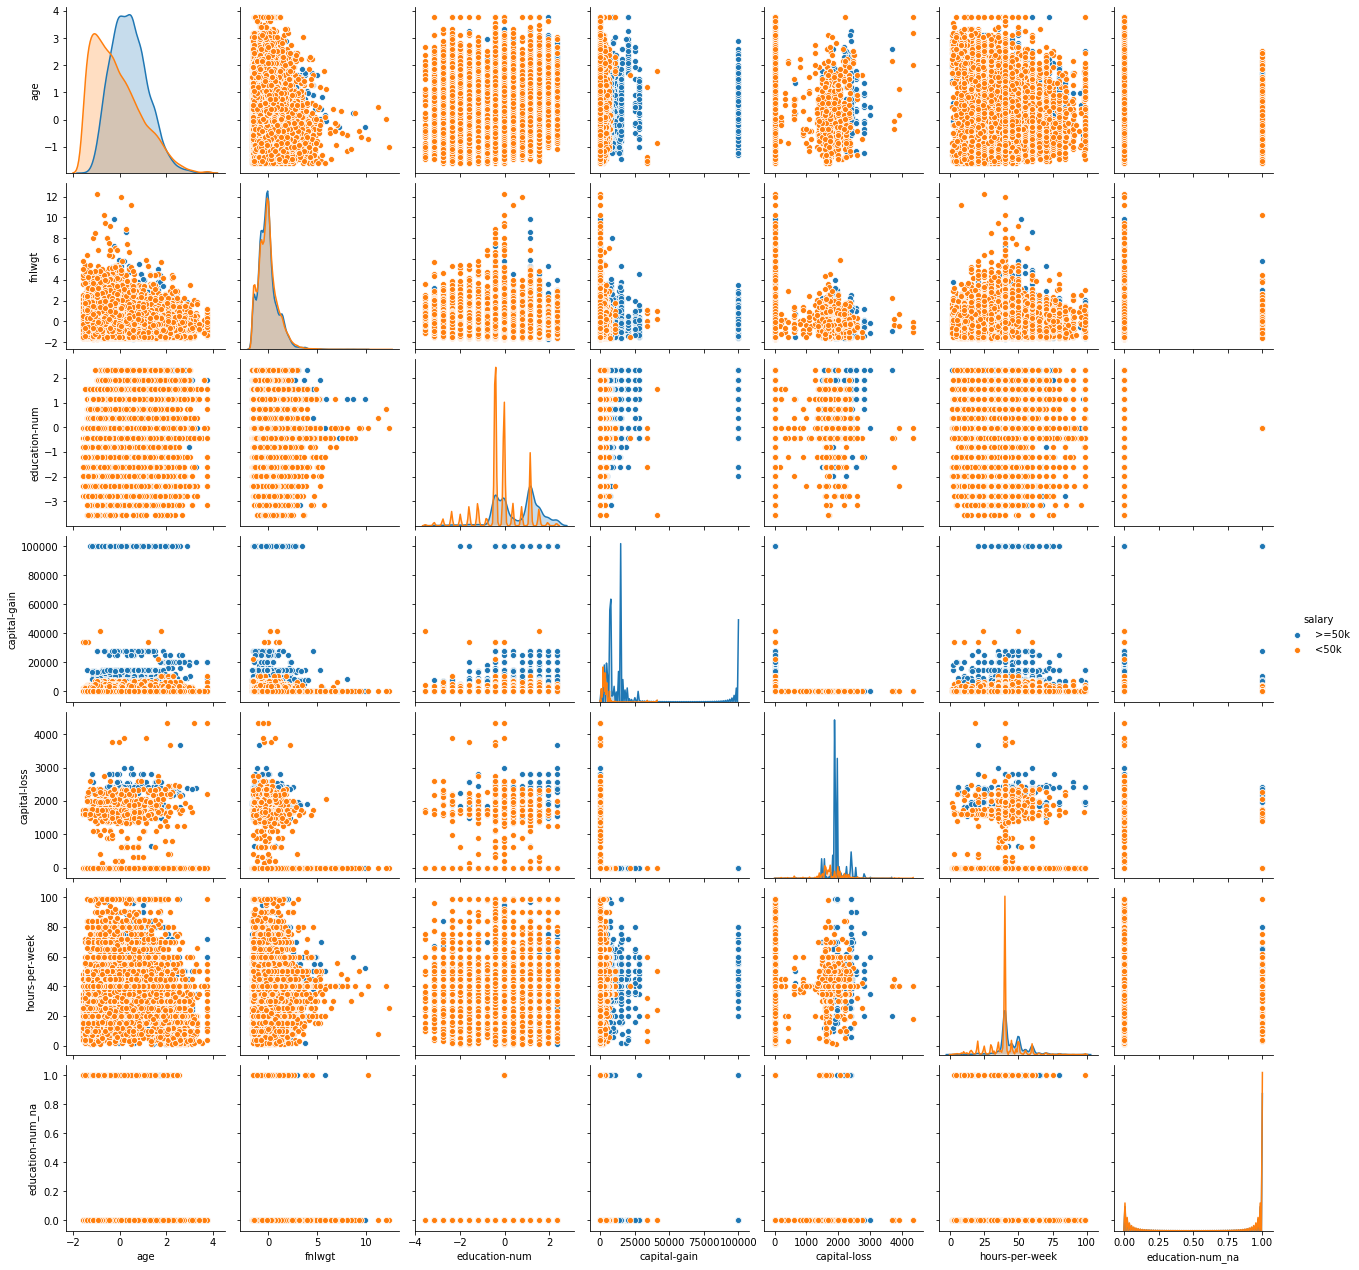

In [0]:
import seaborn as sns
sns.pairplot(data.train_ds.inner_df, hue='salary');

We can also use some calculus to figure out which of the original input features ends up being most predictive of our outcomes!

In [0]:
#@title Run this cell to load a cool feature importance function.

from tqdm import tqdm_notebook as tqdm

#based on https://forums.fast.ai/t/feature-importance-in-deep-learning/42026/19
def feature_importance(learn:Learner): 
    pd.options.mode.chained_assignment = None
    # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    data = learn.data.train_ds.x
    cat_names = data.cat_names
    cont_names = data.cont_names
    loss0=np.array([learn.loss_func(learn.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learn.data.valid_dl)]).mean()
    #The above gives us our ground truth percentage for our validation set
    fi=dict()
    types=[cat_names, cont_names]
    with tqdm(total=len(data.col_names)) as pbar:
      for j, t in enumerate(types): # for all of cat_names and cont_names
        for i, c in enumerate(t):
          loss=[]
          for x,y in (iter(learn.data.valid_dl)): # for all values in validation set
            col=x[j][:,i] # select one column of tensors
            idx = torch.randperm(col.nelement()) # generate a random tensor
            x[j][:,i] = col.view(-1)[idx].view(col.size()) # replace the old tensor with a new one
            y=y.to('cpu')
            loss.append(learn.loss_func(learn.pred_batch(batch=(x,y)), y))
          pbar.update(1)
          fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    
    df = pd.DataFrame({'Variable': [l for l, v in d], 'Importance': np.log1p([v for l, v in d])})
    df['Type'] = ''
    for x in range(len(df)):
      if df['Variable'].iloc[x] in cat_names:
        df['Type'].iloc[x] = 'categorical'
      if df['Variable'].iloc[x] in cont_names:
        df['Type'].iloc[x] = 'continuous'
    return df

In [0]:
feature_importance(learn)

,Variable,Importance,Type
0,marital-status,0.035922,categorical
1,occupation,0.018365,categorical
2,age,0.009677,continuous
3,education,0.009374,categorical
4,education-num,0.008393,continuous
5,workclass,0.003636,categorical
6,education-num_na,0.003189,categorical
7,relationship,0.002015,categorical
8,race,-0.000973,categorical
9,fnlwgt,-0.001592,continuous


##Deep Learning on Image Data

The real juice of deep learning (and the reason we're currently experiencing a renaissance of artificial intelligence research) is because until about six years ago, every introduction to psychology class began by saying: 'computers can't even properly recognize objects from two different angles'. 

Now, they can. And almost spectacularly so.

Here, we'll fit a deep neural network to recognize objects in images. Giddy up!

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

###The Shape Central Dataset

The dataset you just downloaded is a dataset I made in Blender, a 3D animation interface. (If you want to have a look at the generative code, feel free to check out this Github [page](https://github.com/ColinConwell/ShapeCentral).)

It consists of simple objects viewed under a number of variable viewing conditions. Those variables are as follows:


*   Position
*   Rotation
*   Texture

The last of these variables is meant to deliberately foil a very common technique deep networks use to recognize objects; specifically, to identify small, but highly discriminative patches of pixels that given the statistical contingencies of large datasets, sometimes seperate one object from another by chance alone!

(Remember the apocryphal allegory of the Russian versus American tanks).

Without further ado, then, let's have a look!


In [6]:
gdd.download_file_from_google_drive(file_id='10WzhgUaRRZMQ9rm020ApZHhq6GvNLZoe',
                                    dest_path='./simple_shapes.tar.bz2',
                                    overwrite=True,
                                    unzip=False)

In [0]:
!tar xfj simple_shapes.tar.bz2

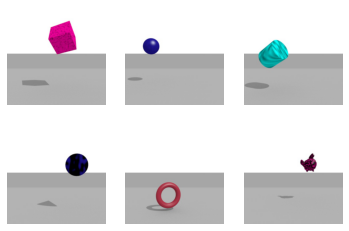

In [8]:
images = [plt.imread(f"SimpleShapes/00001{i}.jpg") for i in ['Cube', 'Sphere', 'Cylinder', 'Cone', 'Torus', 'Suzanne']]

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True) 

for img, ax in zip(images, axes.flat):
    ax.imshow(img)
    ax.axis('off')

In [0]:
from PIL import Image

Notice some of these are harder than others: Here is a cone that is distinguishable from a sphere only by its shadow.

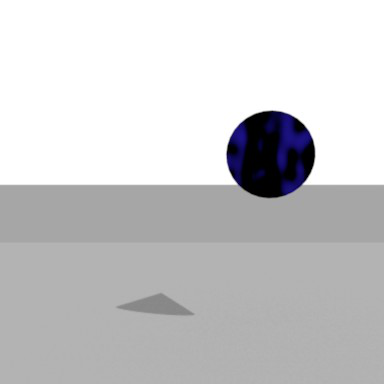

In [10]:
Image.open('SimpleShapes/00001Cone.jpg')

###Dataset Preparation

Our first step with a dataset of this sort is to create a dataframe with the paths to all the data files (in this case, the images) and a label associated with that data file (in this case, the identity of the object in the image). 

In [0]:
assets = glob('SimpleShapes/*.jpg')
dictlist = []
for asset in assets:
    imgstr = asset.split('/')[1]
    index = imgstr[:5]
    item = imgstr[5:imgstr.rfind('.')]
    row = {'ImageName': imgstr, 'ImageIndex': index, 'Object': item}
    dictlist.append(row)
labelcsv = pd.DataFrame(dictlist)

Our completed labels dataframe should appear as follows:

In [12]:
labelcsv.head()

,ImageName,ImageIndex,Object
0,00380Cone.jpg,00380,Cone
1,00794Sphere.jpg,00794,Sphere
2,00048Suzanne.jpg,00048,Suzanne
3,00535Torus.jpg,00535,Torus
4,00758Cone.jpg,00758,Cone


Another very necessary step is to define the path where your data can be found!

In [0]:
path = Path('SimpleShapes')
df = labelcsv

Here are various model options for the pretrained neural network we'll be using as a base for classification.

In [0]:
model_ids = {'vgg16': models.vgg16_bn, 'vgg19': models.vgg19_bn, 'resnet18': models.resnet18, 'resnet34': models.resnet34,
             'resnet50': models.resnet50, 'resnet152': models.resnet152}

###Experiments | Training & Test Splits

A generally good idea with any machine learning experiment is to create one long string that you can use to save the various files associated with the experiment (the final model weights, for example). This one long string should consist of all the variables that define how your model will be trained -- things like the dataset used, the number of items to use for training and test, and how many iterations to run when training the model.


In [15]:
experiment = {'train_data': 'SimpleShapes',
              'test_data': 'SimpleShapes',
              'subset': 'Stack_3',
              'model': 'resnet18', 
              'finetuning': False, 
              'trainCycles': 3, 
              'trainSetSize': 800,
              'valSetSize': 200}
'_'.join('{}_{}'.format(key, val) for key, val in experiment.items())

'train_data_SimpleShapes_test_data_SimpleShapes_subset_Stack_3_model_resnet18_finetuning_False_trainCycles_3_trainSetSize_800_valSetSize_200'

Next, we need to define a function to split our data into training and validation sets, but in such a way that the split is random.

In [0]:
from random import shuffle
def shuffling_split(train_size, test_size, n_splits=1):
    total_size = train_size + test_size
    indices = [i for i in range(1,total_size+1)]
    train_indices = []
    test_indices = []
    for i in range(n_splits):
        indices = [i for i in range(1,total_size+1)]
        shuffle(indices)
        train = indices[:train_size]
        test = indices[train_size:]
        train_indices.append(train)
        test_indices.append(test)
    if n_splits == 1:
        return train_indices[0], test_indices[0]
    if n_splits > 1:
        return train_indices, test_indices

Using the indices fed by this function, we can then relabel our dataset with indicators of which items should be treated as 'training' and which items should be treated as 'test'.

In [17]:
test_indices = shuffling_split(experiment['trainSetSize'], experiment['valSetSize'])[1]
df['TestSet'] = pd.to_numeric(df['ImageIndex']).isin(test_indices)
print('Proportion of Labels in Training')
print(df['Object'].value_counts())
print('Training and Testing Set Sizes')
print(df['TestSet'].value_counts())
df.head()

Proportion of Labels in Training
Suzanne     1000
Cube        1000
Cylinder    1000
Sphere      1000
Torus       1000
Cone        1000
Name: Object, dtype: int64
Training and Testing Set Sizes
False    4800
True     1200
Name: TestSet, dtype: int64


,ImageName,ImageIndex,Object,TestSet
0,00380Cone.jpg,00380,Cone,False
1,00794Sphere.jpg,00794,Sphere,False
2,00048Suzanne.jpg,00048,Suzanne,True
3,00535Torus.jpg,00535,Torus,False
4,00758Cone.jpg,00758,Cone,False


In [0]:
data = (ImageList.from_df(df, path, cols='ImageName')
                   .split_from_df(col='TestSet')
                   .label_from_df(cols='Object')
                   .transform(get_transforms(), size=224)
                   .databunch(bs=48)).normalize(imagenet_stats)

###Model Training

And now, in four beautiful lines of code, we define and train our model.

In [19]:
learn = cnn_learner(data, model_ids[experiment['model']],  metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [21]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

The following function attempts to find an optimal learning rate with which to train your model.

In [0]:
learn.lr_find();

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


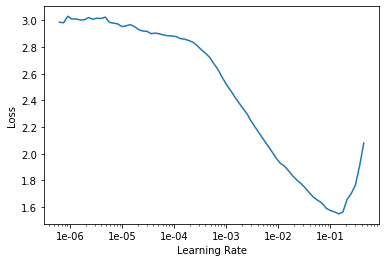

In [0]:
learn.recorder.plot()

(Generally speaking, we want to select a learning rate at or slightly to the left of the elbow in the learning rate finder plot).

In [0]:
learn.fit_one_cycle(experiment['trainCycles'], max_lr=1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,1.466212,4.798079,0.598333,00:49
1,0.787840,0.711978,0.825833,00:50
2,0.286053,0.068332,0.973333,00:50


And voila! You have now fit perhaps your first image recognition network! Notice it's achieved rather marvelous accuracy. Let's have a look inside to get a sense of how and with what information the network has accomplished this.

###Interpretation & Visualization

In [0]:
#@title Run this cell to initialize some cool visualization functions.

from fastai.callbacks.hooks import *

def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

The following tool is called a 'gradient camera'. It shows us which parts of the image were most consequential for the network's ultimate decision. Notice here the network (rather logically) has paid attention mostly to the objects (but also a bit to the objects' shadows).

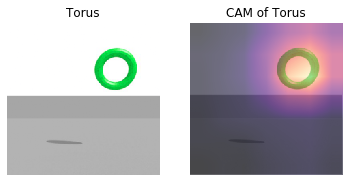

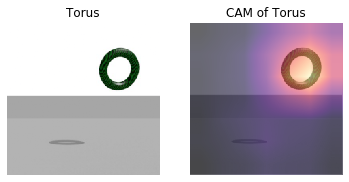

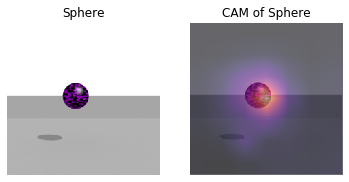

In [0]:
for idx in range(3):
    visualize_cnn_by_cam(learn, idx)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

Here are some items the model didn't do so well on, and the gradient cameras that give us some indication why.

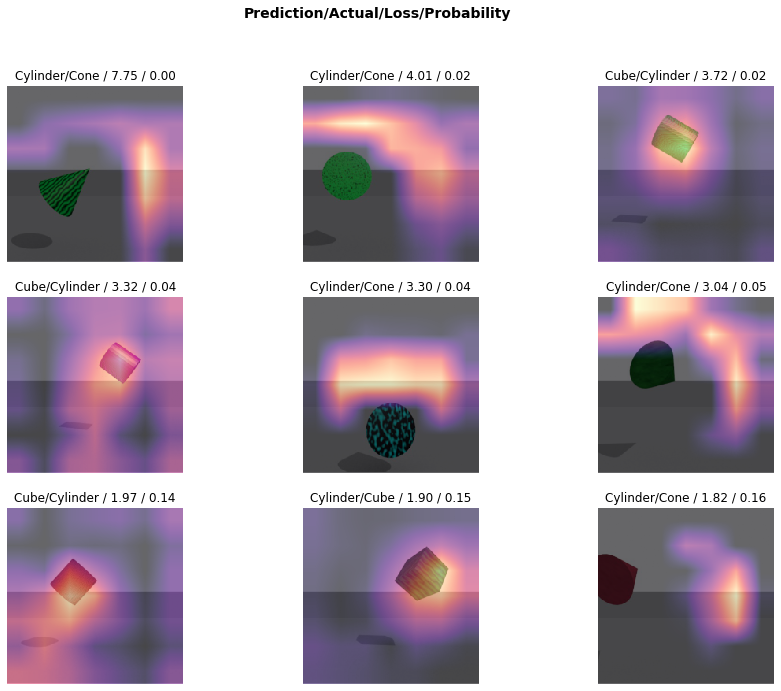

In [0]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

And finally, we look at the model's confusion matrix, a visualization that tells us which items the model most often confused. In our case, it appears the cylinder was the most commonly confused object (swapped semifrequently as it was with the cone and cube).

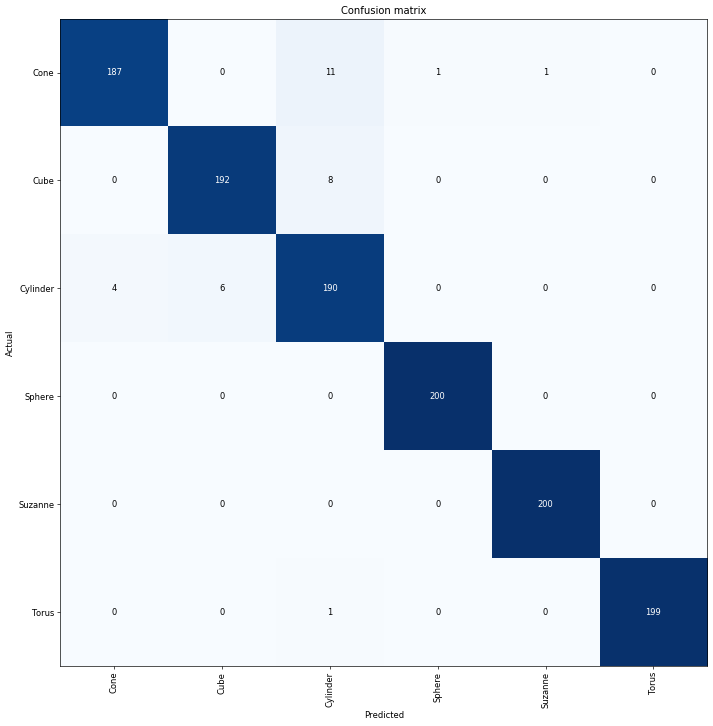

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=10)

[('Cone', 'Cylinder', 11)]

##An Even Larger Dataset

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1aHzog-HB5J2XUH4U32Kw7ioYPrF-jHAy',
                                    dest_path='./more_simple_shapes.tar.bz',
                                    overwrite=True,
                                    unzip=False)

In [0]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1aHzog-HB5J2XUH4U32Kw7ioYPrF-jHAy',
                                    dest_path='./more_simple_shapes.tar.bz',
                                    overwrite=True,
                                    unzip=False)

In [0]:
!tar xf '/content/more_simple_shapes.tar.bz'

In [0]:
assets = glob('more_simple_shapes/*.jpg')
dictlist = []
for asset in assets:
    imgstr = asset.split('/')[1]
    index = imgstr[:5]
    item = imgstr[5:imgstr.rfind('.')]
    testing = 0 if int(index) < 5100 else 1
    row = {'ImageName': imgstr, 'ImageIndex': index, 'Object': item, 'Test': testing}
    dictlist.append(row)
labelcsv = pd.DataFrame(dictlist)

##Representational Similarity Analysis

In [0]:
import torchvision.transforms as transforms
import torch.nn as nn
import torch

from fastai.torch_core import flatten_model

preprocessing = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.clone().detach().requires_grad_(True).cuda()
    def close(self):
        self.hook.remove()
        
def get_layer_names(layers):
    layer_names = []
    for layer in layers:
        layer_name = str(layer).split('(')[0]
        layer_names.append(layer_name + '-' + str(sum(layer_name in string for string in layer_names) + 1))
    return layer_names

def get_activations(model, img, layers, target_layer):
    img_tensor = preprocessing(img).unsqueeze(0).cuda()
    activations = SaveFeatures(layers[target_layer])
    model(img_tensor)
    activations.close()
    return activations.features.detach().cpu().numpy().squeeze()

def flatten_batch(features):
    return features.view(features.size()[0], torch.prod(torch.tensor(features.size()[1:])).item())

In [0]:
model = learn.model
layers = flatten_model(model)
layer_names = get_layer_names(layers)

In [0]:
classifier_rdms = {}
for layer_index, layer in enumerate(tqdm(layers[:-2])):
    image_activations = []
    for image in tqdm(df[df.TestSet == 1]['ImageName'][:10], leave=False):
        image_array = Image.open(path/image)
        image_activations.append(get_activations(model, image_array, layers, layer_index).flatten())
    layer_features = np.stack(image_activations)
    classifier_rdms[layer_names[layer_index]] = np.corrcoef(layer_features)

In [0]:
layer_features

array([[ 0.044653,  0.047549,  1.205085, -0.348379, ..., -0.19102 , -0.019113,  0.044582,  0.031493],
       [ 0.044653,  0.047549,  1.564067, -0.348379, ..., -0.19102 , -0.019113,  0.021588,  0.031493],
       [ 0.044653,  0.047549, -0.116505,  1.001874, ..., -0.19102 , -0.019113,  0.158551,  0.016564],
       [ 0.044653,  0.047549,  1.100859, -0.348379, ..., -0.19102 , -0.019113,  0.063503,  0.031493],
       ...,
       [ 0.196751,  0.047549, -0.116505, -0.348379, ...,  0.912149, -0.040607,  0.158551,  0.031493],
       [ 0.044653,  0.047549, -0.116505, -0.348379, ..., -0.19102 , -0.028105,  0.158551,  0.031493],
       [ 0.215989,  0.047549, -0.116505, -0.348379, ...,  0.864167, -0.03524 ,  0.158551,  0.031493],
       [ 0.044653,  0.047549,  1.115532, -0.348379, ..., -0.19102 , -0.019113,  0.102516,  0.031493]], dtype=float32)

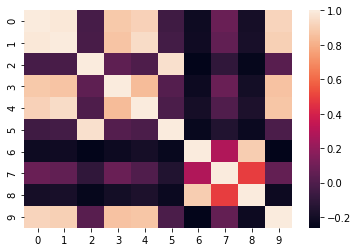

In [0]:
sns.heatmap(classifier_rdms[layer_names[-3]]);

##The Variational Autoencoder

In [0]:
#@title Run this cell to load the autoencoder architecture.
import abc
import torch
from torch import nn
from torch.nn import functional
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models


class AbstractAutoEncoder(nn.Module):
    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def encode(self, x):
        return

    @abc.abstractmethod
    def decode(self, z):
        return

    @abc.abstractmethod
    def forward(self, x):
        """model return (reconstructed_x, *)"""
        return

    @abc.abstractmethod
    def sample(self, size):
        """sample new images from model"""
        return

    @abc.abstractmethod
    def loss_function(self, **kwargs):
        """accepts (original images, *) where * is the same as returned from forward()"""
        return

    @abc.abstractmethod
    def latest_losses(self):
        """returns the latest losses in a dictionary. Useful for logging."""
        return

class ResBlock(nn.Module):
    def __init__(self, in_channels, channels, bn=False):
        super(ResBlock, self).__init__()

        layers = [
            nn.ReLU(),
            nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, channels, kernel_size=1, stride=1, padding=0)]
        if bn:
            layers.insert(2, nn.BatchNorm2d(channels))
        self.convs = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.convs(x)

#Adversarial Convolutional Variational Autoencoder
class ACVAE(AbstractAutoEncoder):
    def __init__(self, input_shape, input_channels=3, latent_dim=128, **kwargs):
        super(ACVAE, self).__init__()
        
        print("Adversarial VAE Model with Resnet Encoder & Latent Space of Size ", latent_dim)
        
        features = torchvision.models.resnet18(pretrained=True)
        self.encoder=nn.Sequential(*(list(features.children())[:-2]))
        
        self.decoder = nn.Sequential(
            ResBlock(input_shape, input_shape, bn=True),
            nn.BatchNorm2d(input_shape),
            ResBlock(input_shape, input_shape, bn=True),
            nn.BatchNorm2d(input_shape),
            
            nn.ConvTranspose2d(input_shape, input_shape, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_shape),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(input_shape, input_shape // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_shape//2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(input_shape // 2, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(16, input_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(input_channels, input_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),   
        )
        
        self.input_shape = input_shape
        #25088 corresponds to the flattened dimensions of the last conv layer of Resnet18
        self.fc_mu = nn.Linear(25088,latent_dim)
        self.fc_std = nn.Linear(25088,latent_dim)
        self.fc_z=nn.Linear(latent_dim,input_shape*4**2)        
    
        self.mse = 0

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(-1, 25088)
        return self.fc_mu(h1), self.fc_std(h1)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, z):
        z=self.fc_z(z)
        z = z.view(-1, self.input_shape, 4, 4)
        h3 = self.decoder(z)
        return torch.tanh(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        self.mu, self.logvar = mu, logvar
        return self.decode(z)#, mu, logvar
    
    def get_latent(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z
        
    def sample(self, size):
        sample = Variable(torch.randn(size, 128), requires_grad=False)
        if self.cuda():
            sample = sample.cuda()
        return self.decode(sample).cpu()
    
    def loss_function(self, x, recon_x):
        self.mse = F.mse_loss(recon_x, x)
        self.kl_loss = -0.5 * torch.sum(1 + self.logvar - self.mu.pow(2) - self.logvar.exp())
        self.kl_loss /= x.size(0) * 3 * 1024
        return 0.5 * self.mse + 1.0 * self.kl_loss

    def latest_losses(self):
        return {'mse': self.mse}

In [2]:
path = Path('more_simple_shapes')
df = labelcsv

NameError: ignored

In [0]:
data = (ImageImageList.from_df(df, path, cols='ImageName')
        #.split_by_rand_pct(0.1, seed=42)
        .split_from_df(col='Test')
        .label_from_func(lambda x: x)
        .transform(get_transforms())
        .databunch(bs=48)).normalize(imagenet_stats)

In [0]:
vae = ACVAE(224, input_channels=3)
learn = Learner(data, vae, opt_func=torch.optim.Adam, loss_func=vae.loss_function)

Adversarial VAE Model with Resnet Encoder & Latent Space of Size  128


In [0]:
#my_learner.load('new_shape_vae_model')

In [0]:
learn.fit_one_cycle(1, max_lr = 1e-4)

epoch,train_loss,valid_loss,time
0,0.253052,0.326232,05:00


In [0]:
sample = torch.randn(64, 128).cuda()
sample = vae.decode(sample).detach().cpu()

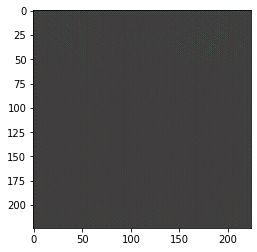

In [0]:
plt.imshow(sample[0].permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


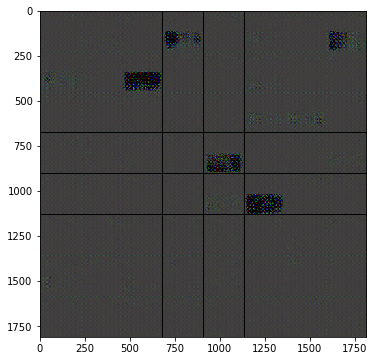

In [0]:
from torchvision.utils import make_grid
fig, ax = plt.subplots(figsize=(18,6))
plt.imshow(sample[0].permute(1, 2, 0));
plt.imshow(make_grid(sample).permute(1,2,0));
#save_image(sample.view(64, 3, 28, 28), 'results/sample_' + '.png')

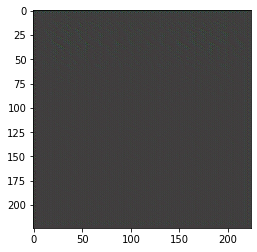

In [0]:
img = Image.open('more_simple_shapes/00001Cone.jpg')
img_tensor = preprocessing(img).unsqueeze(0).cuda()
sample = vae.decode((vae.encode(img_tensor)[0])).detach().cpu()
plt.imshow(sample[0].permute(1, 2, 0));

In [0]:
model = learn.model.encoder
layers = flatten_model(model)
layer_names = get_layer_names(layers)

In [0]:
encoder_rdms = {}
for layer_index, layer in enumerate(tqdm(layers)):
    image_activations = []
    for image in tqdm(df[df.Test == 1]['ImageName'][:10], leave=False):
        image_array = Image.open(path/image)
        image_activations.append(get_activations(model, image_array, layers, layer_index).flatten())
    layer_features = np.stack(image_activations)
    encoder_rdms[layer_names[layer_index]] = np.corrcoef(layer_features)

##Deep Net Species Comparison

In [0]:
from scipy.stats import pearsonr
rdm_dist_dict = []
for layer_index, layer_name in enumerate(layer_names[:-2]):
    rdm1 = encoder_rdms[layer_name]
    rdm2 = classifier_rdms[layer_name]
    rdm1_triu = rdm1[np.triu_indices(rdm1.shape[0], k=1)].flatten()
    rdm2_triu = rdm2[np.triu_indices(rdm2.shape[0], k=1)].flatten()
    rdm_dissimilarity = 1 - pearsonr(np.nan_to_num(rdm1_triu), np.nan_to_num(rdm2_triu))[0]
    rdm_dist_dict.append({'LayerName': layer_name, 'LayerIndex': layer_index, 'Dissimilarity': rdm_dissimilarity})
rdm_dist_df = pd.DataFrame(rdm_dist_dict)

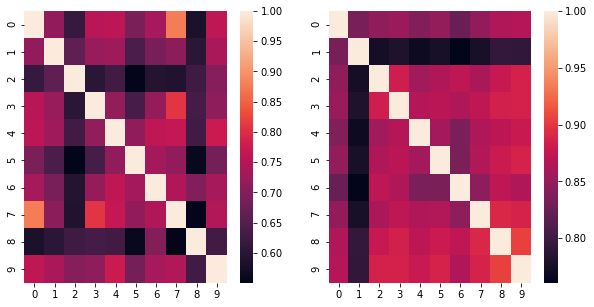

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
sns.heatmap(encoder_rdms[layer_names[1]], ax=ax1)
sns.heatmap(classifier_rdms[layer_names[1]], ax=ax2)
plt.show()

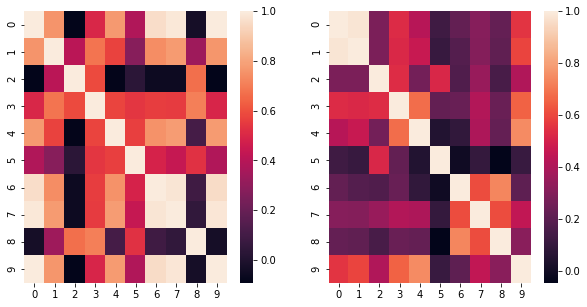

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
sns.heatmap(encoder_rdms[layer_names[-1]], ax=ax1)
sns.heatmap(classifier_rdms[layer_names[-1]], ax=ax2)
plt.show()

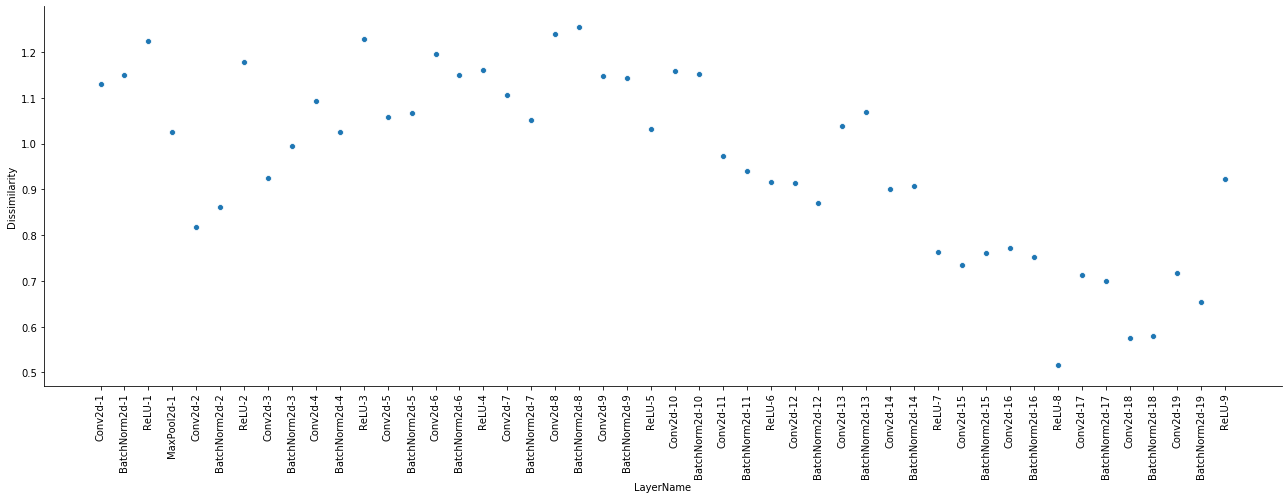

In [0]:
p=sns.relplot(x='LayerName', y='Dissimilarity', data = rdm_dist_df, height = 6, aspect = 3);
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in p.axes.flat];

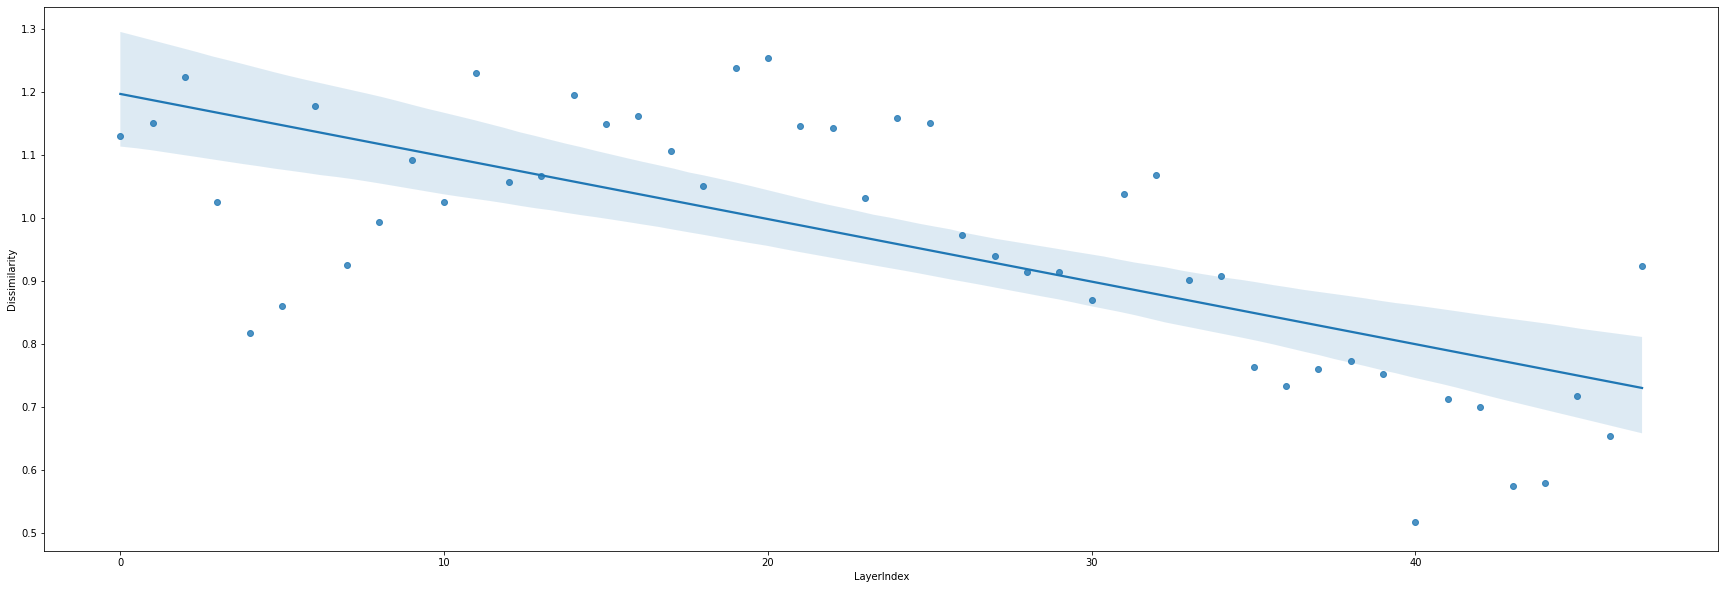

In [0]:
plt.figure(figsize=(30,10))
sns.regplot(x="LayerIndex", y="Dissimilarity", data=rdm_dist_df);